In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

%matplotlib inline

from sklearn.manifold import TSNE
import xgboost


import shap  # https://github.com/slundberg/shap
# load JS visualization code to notebook
shap.initjs()

In [2]:
fundamental = pd.read_csv('../data/SHARADAR-SF1.csv')
ticker = pd.read_csv('../data/SHARADAR_TICKERS.csv')

In [6]:
fundamental.head()

,ticker,dimension,calendardate,datekey,reportperiod,lastupdated,accoci,assets,assetsavg,assetsc,...,sharesbas,shareswa,shareswadil,sps,tangibles,taxassets,taxexp,taxliabilities,tbvps,workingcapital
0,ZZ,MRY,2011-12-31,2011-11-27,2011-11-27,2018-05-16,-509000.0,919194000.0,937199250.0,342095000.0,...,100820532.0,99261000.0,99261000.0,12.393,557052000.0,23121000.0,4104000.0,549000.0,5.612,185598000.0
1,ZYXI,MRY,2017-12-31,2017-12-31,2017-12-31,2018-08-03,0.0,8929000.0,5669750.0,8371000.0,...,32831877.0,32156000.0,33196000.0,0.729,8929000.0,0.0,129000.0,0.0,0.272,4356000.0
2,ZYXI,MRY,2016-12-31,2016-12-31,2016-12-31,2018-08-03,0.0,4091000.0,4343250.0,3422000.0,...,31271234.0,31271000.0,31271000.0,0.426,4057000.0,0.0,15000.0,0.0,0.130,-4323000.0
3,ZYXI,MRY,2015-12-31,2015-12-31,2015-12-31,2018-08-03,0.0,3696000.0,5126750.0,2766000.0,...,31271234.0,31271234.0,31271234.0,0.372,3622000.0,0.0,-57000.0,79000.0,0.116,-4773000.0
4,ZYXI,MRY,2014-12-31,2014-12-31,2014-12-31,2018-08-03,0.0,7114000.0,10856750.0,5705000.0,...,31271234.0,31207672.0,31207672.0,0.356,6983000.0,268000.0,-49000.0,79000.0,0.223,-2352000.0


In [7]:
ticker.head()

,ticker,firstpricedate,sector,industry
0,A,1999-11-18,Healthcare,Diagnostics & Research
1,AA,2016-11-01,Basic Materials,Aluminum
2,AAAB,1998-09-28,Financial Services,Banks - Regional - US
3,AAAGY,2002-05-22,Healthcare,Biotechnology
4,AAAP,2015-11-11,Healthcare,Biotechnology


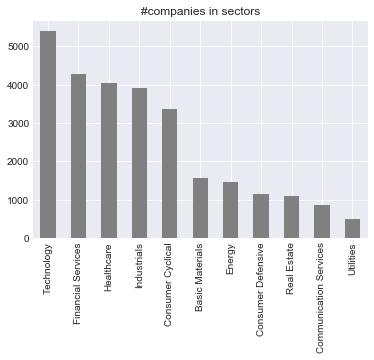

In [8]:
# sns.countplot(ticker['sector'], color='gray')
ticker['sector'].value_counts().plot(kind='bar', title='#companies in sectors', color='grey',)

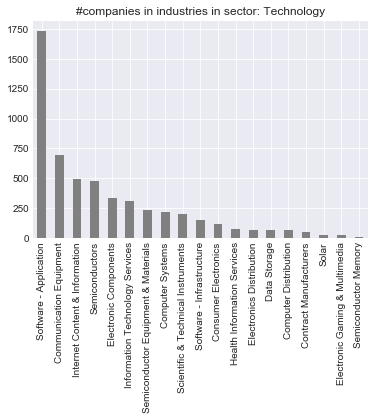

In [9]:
sector = 'Technology'
ticker[ticker['sector'] == sector]['industry'].value_counts().plot(kind='bar', title=f'#companies in industries in sector: {sector}', color='grey')

# Segmentation of companies of one industry by annual returns

In [10]:
sector = 'Technology'
industry = 'Software - Application'

tickers = ticker[(ticker.sector == sector) & (ticker.industry == industry)]['ticker'].unique()
print(f'#tickers of sector: {sector} and industry: {industry}: {len(tickers)}')

tickers = fundamental[fundamental['ticker'].isin(tickers)]['ticker'].unique()
print(f'#tickers with fundamental data of sector: {sector} and industry: {industry}: {len(tickers)}')

#tickers of sector: Technology and industry: Software - Application: 872
#tickers with fundamental data of sector: Technology and industry: Software - Application: 81


Text(0.5,1,'Annual revenue by companies')

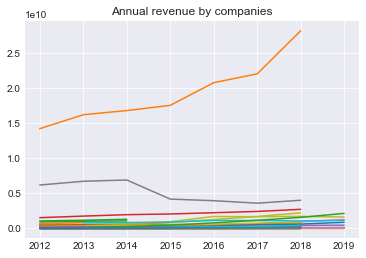

In [11]:
# fundamentdal[fundamentdal['ticker'] == 'SAP'].set_index('datekey')[['roe', 'revenue']].plot(secondary_y='roe')

def indicator_df(df, indicator, freq='Y'):
    indicator_df = df[['datekey', 'ticker', indicator]].pivot(index='datekey', columns='ticker', values=indicator)
    indicator_df.index = pd.to_datetime(indicator_df.index)
    indicator_df = indicator_df.resample('Y').last()
    return indicator_df

revenue = indicator_df(df=fundamental[fundamental['ticker'].isin(tickers)], indicator='revenue', freq='Y')

for c in revenue:
    plt.plot(revenue[c].dropna().index, revenue[c].dropna().values, label=c)
plt.title('Annual revenue by companies')

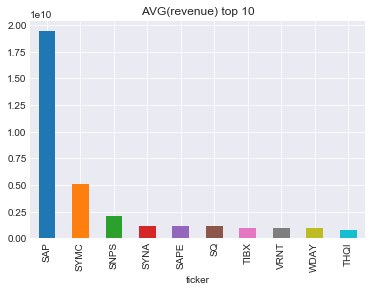

In [12]:
revenue.mean().sort_values(ascending=False).head(10).plot(kind='bar', title='AVG(revenue) top 10')

Text(0.5,1,'boxplot of annual revenue')

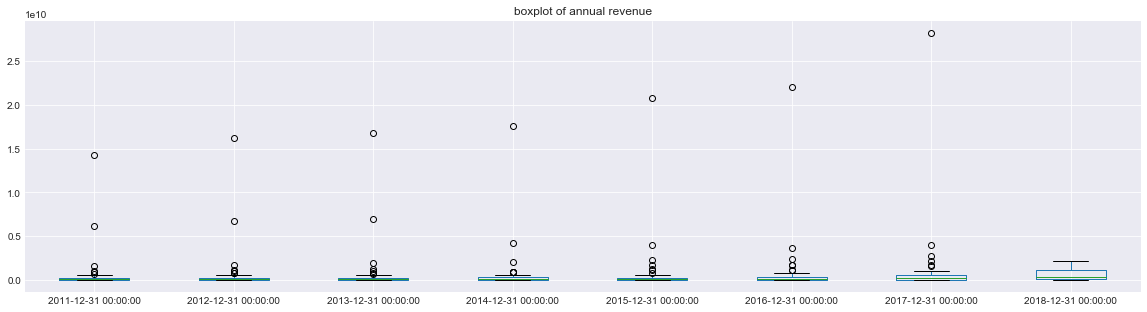

In [13]:
revenue.T.boxplot(figsize=(20, 5))
plt.title('boxplot of annual revenue')

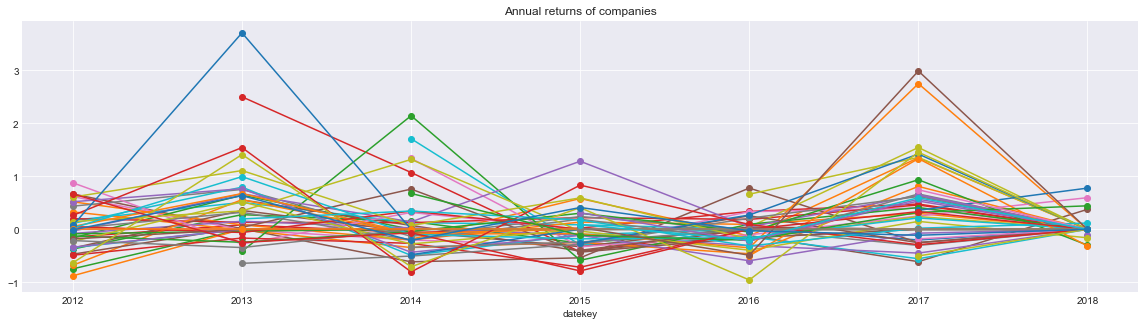

In [14]:
price = indicator_df(df=fundamental[fundamental['ticker'].isin(tickers)], indicator='price', freq='Y')
returns = price.pct_change()
returns.plot(style='o-', figsize=(20, 5), legend=False, title='Annual returns of companies')

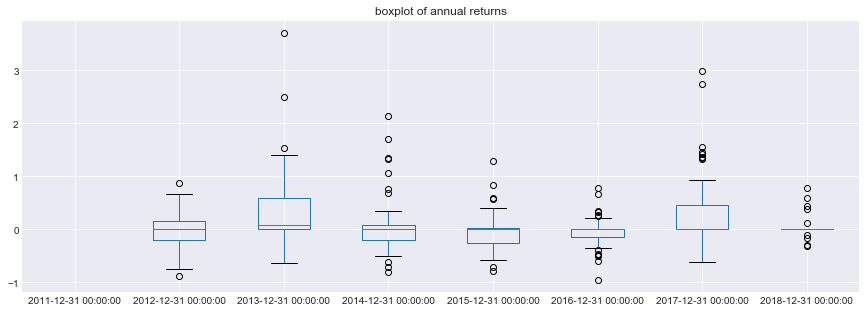

(Text(0.5,1,'boxplot of annual returns'), None)

In [15]:
returns.T.boxplot(figsize=(15, 5))
plt.title('boxplot of annual returns'), plt.show()

# Create dataset

In [14]:
X_names = ['revenue', 'ebitda', 'roe', 'opex', 'capex', 'rnd', 'equity', 'debt', 'ev', 'fcf']
# scalers = dict()
data = dict()

for t in tickers[:]:
    ticker_data = fundamental[fundamental['ticker']==t][['ticker', 'datekey', 'price'] + X_names].set_index('datekey')
    ticker_data.index = pd.to_datetime(ticker_data.index)
    ticker_data = ticker_data.resample('Y').last()
    ticker_data['returns'] = ticker_data['price'].pct_change()
    ticker_data = ticker_data.iloc[1:]
    ticker_data.drop('price', axis='columns', inplace=True)
    data[t] = ticker_data.reset_index()
    # print(f'{t}: {data[t].shape[1]}')    


X_ = pd.concat([data[t] for t in data], axis='rows')

In [15]:
y = X_.dropna()['returns']
X = X_.dropna().drop(['datekey', 'ticker', 'returns'], axis='columns')

# t-SNE

In [16]:
# Scale and visualize the embedding vectors
def plot_embedding(X, y, title=None, figize=(9, 6)):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=figize)
    ax = plt.subplot(111)
    ax. scatter(X[:,0], X[:, 1])
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(round(y[i], 2)),
                 color=plt.cm.Set1(y[i]),
                 fontdict={'weight': 'bold', 'size': 9})
        
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

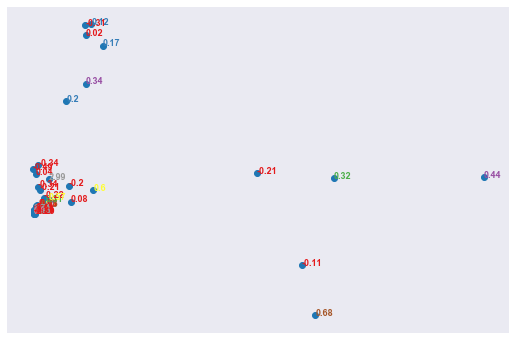

In [84]:
# plt.scatter(tsne_representation[:,0], tsne_representation[:, 1])

tsne = TSNE(n_components=2, init='pca', random_state=0)
plot_embedding(tsne.fit_transform(X), y.values)

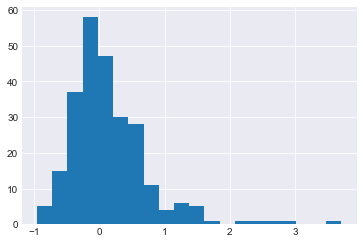

In [17]:
y.hist(bins=20)

In [18]:
y.quantile(0.25)

-0.23241786752060734

In [19]:
y.median()

0.029180945020851223

# Model fit

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, shuffle=False)

In [87]:
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X_train, label=y_train), num_boost_round=100)

In [88]:
print(f'RMSE (test): {np.sqrt(mean_squared_error(y_test, model.predict(xgboost.DMatrix(X_test))))}')
print(f'MAE (test): {np.sqrt(mean_absolute_error(y_test, model.predict(xgboost.DMatrix(X_test))))}')
print(f'RMSE (train): {np.sqrt(mean_squared_error(y_train, model.predict(xgboost.DMatrix(X_train))))}')
print(f'MAE (train): {np.sqrt(mean_absolute_error(y_train, model.predict(xgboost.DMatrix(X_train))))}')

RMSE (test): 0.8784084403174355
MAE (test): 0.8531795472988744
RMSE (train): 0.5029392756178546
MAE (train): 0.5930584424937413


In [89]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [90]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X)

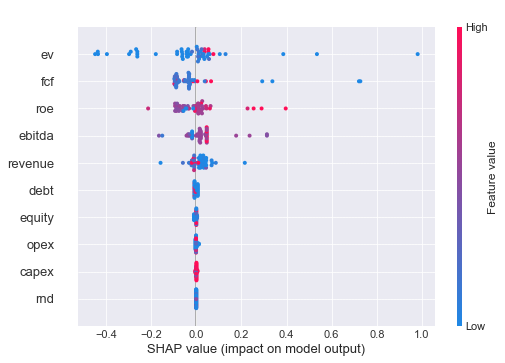

In [91]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X)

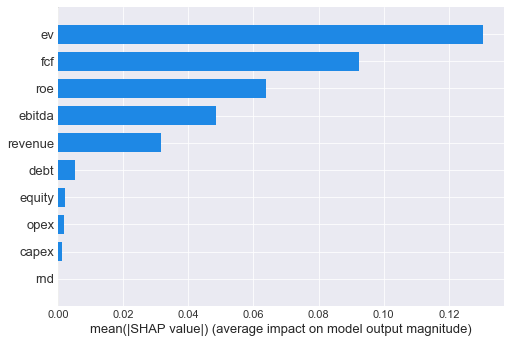

In [92]:
shap.summary_plot(shap_values, X, plot_type="bar")

# One asset one model

In [16]:
def data_for_ticker(fundamental, ticker, X_names):
    ticker_data = fundamental[fundamental['ticker']==t][['ticker', 'datekey', 'price'] + X_names].set_index('datekey')
    ticker_data.index = pd.to_datetime(ticker_data.index)
    ticker_data = ticker_data.resample('Y').last()
    ticker_data['returns'] = ticker_data['price'].pct_change()
    ticker_data = ticker_data.iloc[1:]
    ticker_data.drop('price', axis='columns', inplace=True)
    #Xy = ticker_data.reset_index()
    Xy = ticker_data
    #X, y = Xy.drop(['datekey', 'ticker', 'returns'], axis='columns'), Xy['returns']
    X, y = Xy.drop(['returns'], axis='columns'), Xy['returns']
    return X, y

In [23]:
X_names = ['revenue', 'ebitda', 'roe'] #, 'opex', 'capex', 'rnd', 'equity', 'debt', 'ev', 'fcf']
train_test_split = '2015-12-31'
# train_test_split = '2017-12-31'
scaler = dict()
X, y = dict(), dict()
X_train, y_train = dict(), dict()
X_test, y_test = dict(), dict()
tickers_for_train = pd.Series()
tickers_for_test = pd.Series()

for t in tickers[:30]:
    X_, y_ = data_for_ticker(fundamental, t, X_names)
    if (not (X_.empty or y_.empty)) and (not (X_.isnull().any().any() or y_.isnull().any())) and (X_.shape[0]==6 and y_.shape[0]==6):
        # add lags of X
        for f in X_:
            if f != 'ticker':
                X_[f'{f}__lag_1'] = X_[f].shift()
                X_.drop(f, axis='columns', inplace=True)
        X_ = X_.iloc[1:]
        y_ = y_.iloc[1:]
        #print(X_)
        
        X[t], y[t] = X_.copy(), y_.copy()
        print(f'{t}', end=' ')#, print(X_), print(), print(y_), print()
        tickers_for_train = tickers_for_train.append(X_['ticker'].loc[:train_test_split])
        tickers_for_test = tickers_for_test.append(X_['ticker'].loc[train_test_split:])
        #X_.drop(['datekey', 'ticker'], axis='columns', inplace=True)
        #X_.set_index('datekey', inplace=True)
        X_.drop(['ticker'], axis='columns', inplace=True)
        X_train[t], X_test[t] = X_.loc[:train_test_split], X_.loc[train_test_split:]
        y_train[t], y_test[t] = y_.loc[:train_test_split], y_.loc[train_test_split:]
        #print('X_train'), print(X_train[t])
        scaler[t] = StandardScaler()
        X_train[t] = pd.DataFrame(data=scaler[t].fit_transform(X_train[t]), columns=X_train[t].columns, index=X_train[t].index)
        X_test[t] = pd.DataFrame(data=scaler[t].transform(X_test[t]), columns=X_test[t].columns, index=X_test[t].index)

ZIXI WDDD VRNT VRME VCSY TYPE TYL 

In [24]:
# X_train_all_assets = pd.concat([pd.concat([X_train[t] for t in X_train], axis='rows'), tickers_for_train.to_frame()], axis='columns')       
X_train_all_assets = pd.concat([X_train[t] for t in X_train], axis='rows')       
y_train_all_assets = pd.concat([y_train[t] for t in y_train], axis='rows')
X_test_all_assets = pd.concat([X_test[t] for t in X_test], axis='rows')       
y_test_all_assets = pd.concat([y_test[t] for t in y_test], axis='rows')

In [25]:
X_train_all_assets.head()

,revenue__lag_1,ebitda__lag_1,roe__lag_1
datekey,,,
2013-12-31,-1.344969,0.437175,1.009109
2014-12-31,0.293944,0.946169,0.353510
2015-12-31,1.051025,-1.383344,-1.362619
2013-12-31,0.000000,0.262887,-0.025136
2014-12-31,0.000000,-1.334842,1.237119


In [26]:
y_train_all_assets.head()

datekey
2013-12-31    0.634409
2014-12-31   -0.210526
2015-12-31    0.411111
2013-12-31   -0.250000
2014-12-31   -0.066667
Name: returns, dtype: float64

## XGboost

In [27]:
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X_train_all_assets, label=y_train_all_assets), num_boost_round=100)

print(f'RMSE (test): {np.sqrt(mean_squared_error(y_test_all_assets, model.predict(xgboost.DMatrix(X_test_all_assets))))}')
print(f'MAE (test): {np.sqrt(mean_absolute_error(y_test_all_assets, model.predict(xgboost.DMatrix(X_test_all_assets))))}')
print(f'RMSE (train): {np.sqrt(mean_squared_error(y_train_all_assets, model.predict(xgboost.DMatrix(X_train_all_assets))))}')
print(f'MAE (train): {np.sqrt(mean_absolute_error(y_train_all_assets, model.predict(xgboost.DMatrix(X_train_all_assets))))}')

RMSE (test): 0.6373569367992484
MAE (test): 0.7028468587333644
RMSE (train): 0.37488684524609167
MAE (train): 0.5248607906750307


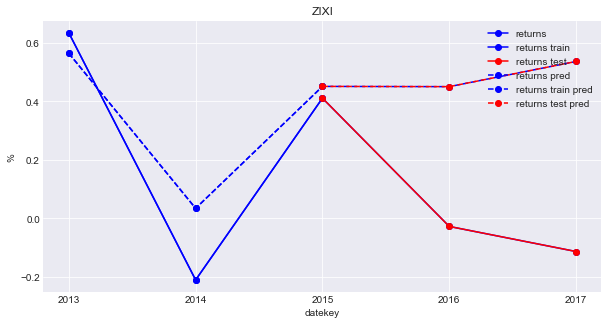

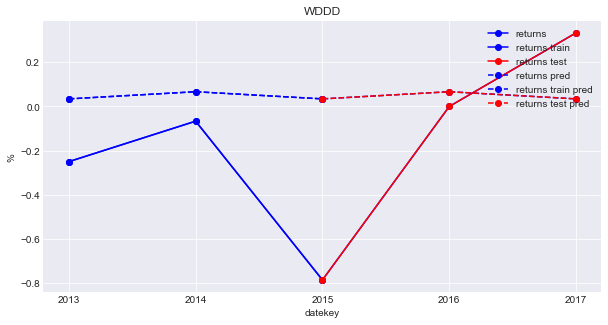

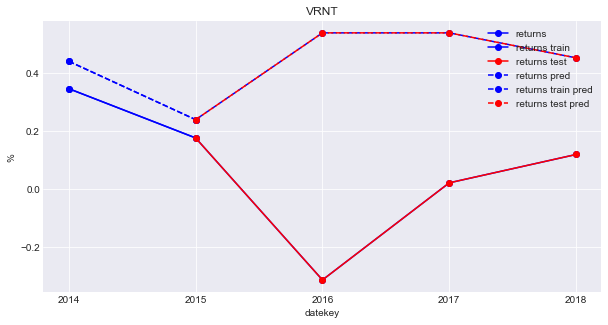

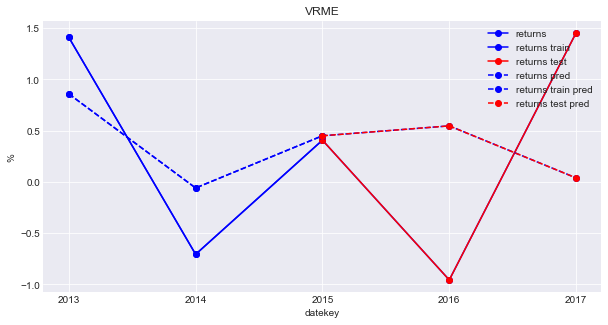

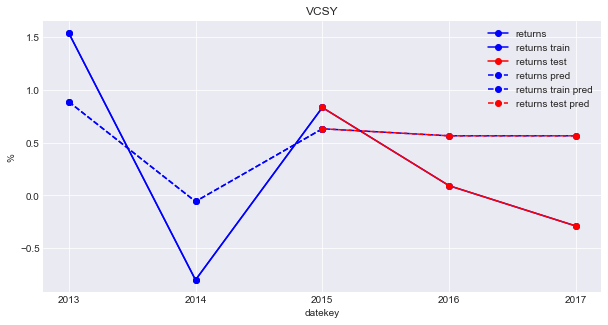

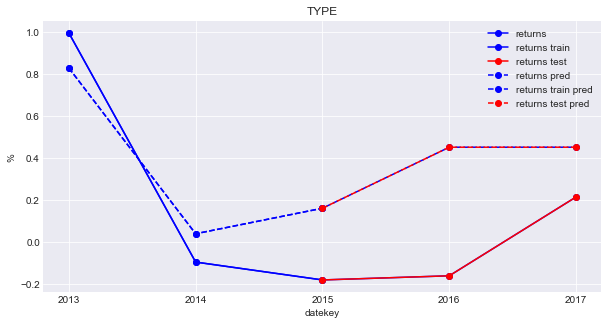

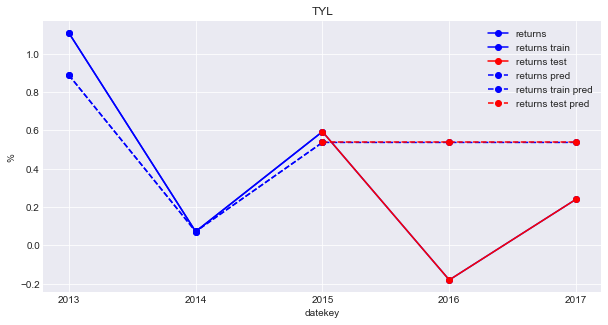

In [28]:
for t in X_test: #['ZIXI', 'WDDD']: #X_test:
    #print(t)
    y_train_pred = pd.Series(data=model.predict(xgboost.DMatrix(X_train[t])), index=y_train[t].index, name=y_train[t].name)
    y_test_pred = pd.Series(data=model.predict(xgboost.DMatrix(X_test[t])), index=y_test[t].index, name=y_test[t].name)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set(title=t, xlabel='Date', ylabel='%')
    y[t].plot(ax=ax, style='bo-')
    y_train[t].plot(ax=ax, style='bo-', label=f'{y_train[t].name} train')
    y_test[t].plot(ax=ax, style='ro-', label=f'{y_test[t].name} test')
    y_train_pred.append(y_test_pred).rename(f'{y_train_pred.name} pred').plot(ax=ax, style='bo--')
    y_train_pred.plot(ax=ax, style='bo--', label=f'{y_train_pred.name} train pred')
    y_test_pred.plot(ax=ax, style='ro--', label=f'{y_test_pred.name} test pred')
    legend = ax.legend(loc='upper right')

## GP 

In [29]:
import GPy


Name : GP regression
Objective : 23.624725004019986
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |   0.5186224069171641  |      +ve      |        
  rbf.lengthscale          |  0.21142631710926757  |      +ve      |        
  Gaussian_noise.variance  |   0.5141598547738551  |      +ve      |        


 C:\Users\ktsyganov\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\contour.py:960: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


 C:\Users\ktsyganov\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


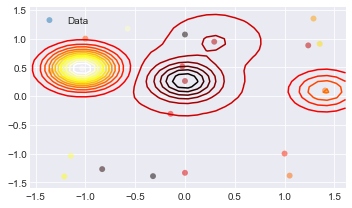

In [30]:
input_dim = X_train_all_assets.shape[1]
kernel = GPy.kern.RBF(input_dim, variance=1, lengthscale=0.2)

model = GPy.models.GPRegression(X_train_all_assets, y_train_all_assets.to_frame(), kernel)
model.optimize()
print(model)
model.plot(figsize=(5, 3), visible_dims=[0, 1])

In [31]:
print(f'RMSE (test): {np.sqrt(mean_squared_error(y_test_all_assets, model.predict(X_test_all_assets.values)[0]))}')
print(f'MAE (test): {np.sqrt(mean_absolute_error(y_test_all_assets, model.predict(X_test_all_assets.values)[0]))}')
print(f'RMSE (train): {np.sqrt(mean_squared_error(y_train_all_assets, model.predict(X_train_all_assets.values)[0]))}')
print(f'MAE (train): {np.sqrt(mean_absolute_error(y_train_all_assets, model.predict(X_train_all_assets.values)[0]))}')

RMSE (test): 0.44150066500121643
MAE (test): 0.5475265573273635
RMSE (train): 0.363334625892397
MAE (train): 0.5449321915103736


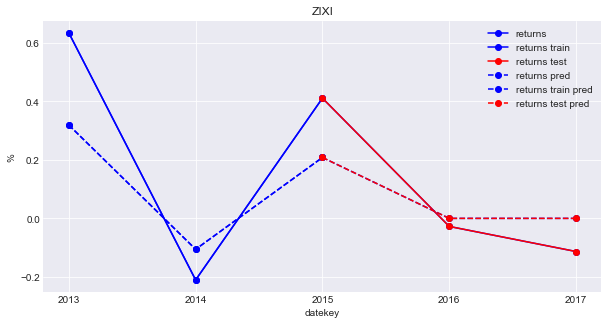

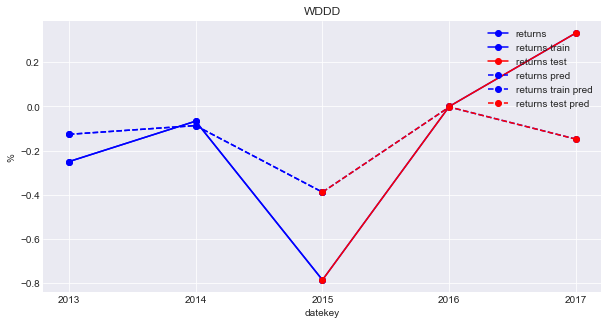

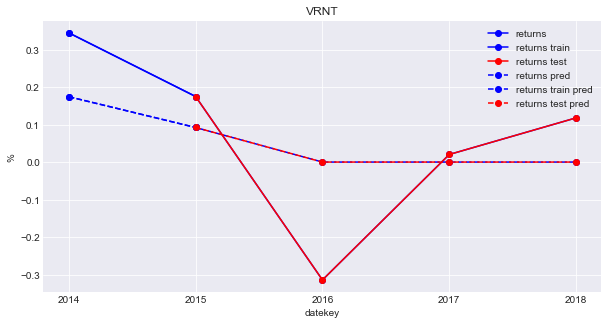

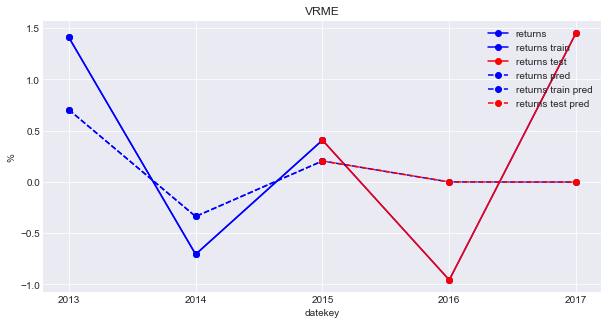

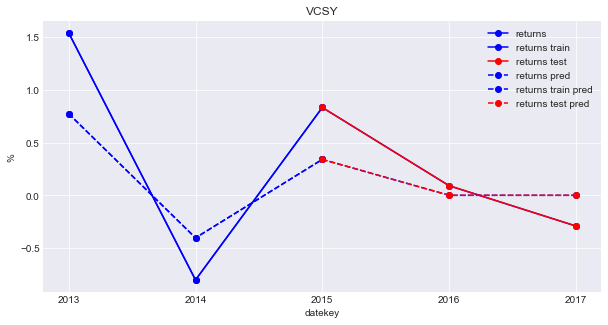

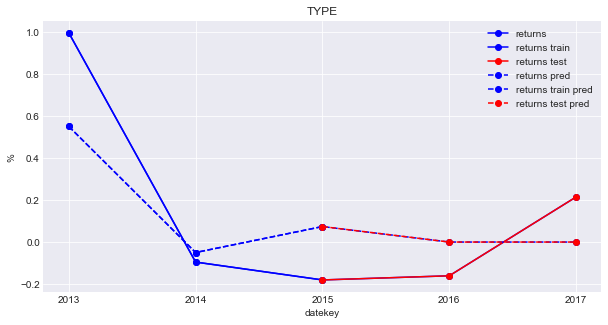

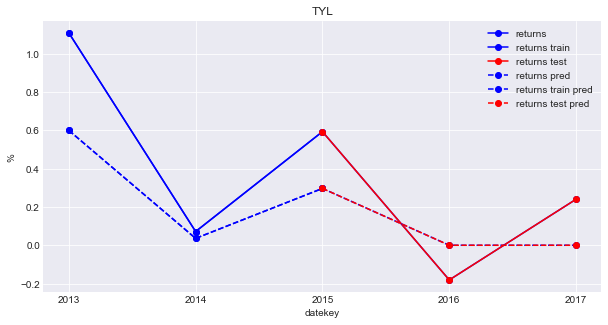

In [32]:
for t in X_test: #['ZIXI', 'WDDD']: #X_test:
    #print(t)
    y_train_pred = pd.Series(data=model.predict(X_train[t].values)[0][:, 0], index=y_train[t].index, name=f'{y_train[t].name} train pred')
    y_test_pred = pd.Series(data=model.predict(X_test[t].values)[0][:, 0], index=y_test[t].index, name=f'{y_test[t].name} test pred')
    y_pred_lb, y_pred_ub = model.predict_quantiles(X_train[t].append(X_test[t]).values)#[:, 0]
    y_pred_lb = pd.Series(data=y_pred_lb[:, 0], index=y_train[t].append(y_test[t]).index, name=f'{y_train[t].name} pred lb')
    y_pred_ub = pd.Series(data=y_pred_ub[:, 0], index=y_train[t].append(y_test[t]).index, name=f'{y_train[t].name} pred ub')
      
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set(title=t, xlabel='Date', ylabel='%')
    y[t].plot(ax=ax, style='bo-')
    y_train[t].plot(ax=ax, style='bo-', label=f'{y_train[t].name} train')
    y_test[t].plot(ax=ax, style='ro-', label=f'{y_test[t].name} test')
    y_train_pred.append(y_test_pred).rename(f'{y_train[t].name} pred').plot(ax=ax, style='bo--')
    y_train_pred.plot(ax=ax, style='bo--')
    y_test_pred.plot(ax=ax, style='ro--')
    #ax.fill_between(y_train[t].append(y_test[t]).index, y_pred_lb, y_pred_ub, color='k', alpha=0.1)
    legend = ax.legend(loc='upper right')